In [349]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip, ImageClip

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [298]:
import datetime

from scipy.stats import mode

import pytesseract
import PIL

In [28]:
def load_percent_template():
    """Loads the % template in black and white"""
    TEMPLATE = mpimg.imread('percent_template.jpg')
    TEMPLATE = cv2.cvtColor(TEMPLATE, cv2.COLOR_RGB2GRAY)
    return TEMPLATE

In [338]:
# Initialize templates of digits
zero = mpimg.imread('digits/0.jpg')
one = mpimg.imread('digits/1.jpg')
two = mpimg.imread('digits/2.jpg')
three = mpimg.imread('digits/3.jpg')
four = mpimg.imread('digits/4.jpg')
five = mpimg.imread('digits/5.jpg')
six = mpimg.imread('digits/6.jpg')
seven = mpimg.imread('digits/7.jpg')
eight = mpimg.imread('digits/8.jpg')
nine = mpimg.imread('digits/9.jpg')

oneGray = cv2.cvtColor(one, cv2.COLOR_RGB2GRAY)
twoGray = cv2.cvtColor(two, cv2.COLOR_RGB2GRAY)
threeGray = cv2.cvtColor(three, cv2.COLOR_RGB2GRAY)
fourGray = cv2.cvtColor(four, cv2.COLOR_RGB2GRAY)
fiveGray = cv2.cvtColor(five, cv2.COLOR_RGB2GRAY)
sixGray = cv2.cvtColor(six, cv2.COLOR_RGB2GRAY)
sevenGray = cv2.cvtColor(seven, cv2.COLOR_RGB2GRAY)
eightGray = cv2.cvtColor(eight, cv2.COLOR_RGB2GRAY)
nineGray = cv2.cvtColor(nine, cv2.COLOR_RGB2GRAY)
zeroGray = cv2.cvtColor(zero, cv2.COLOR_RGB2GRAY)

digit_templates = [zeroGray, oneGray, twoGray, threeGray, fourGray, fiveGray, sixGray, sevenGray, eightGray, nineGray]

In [339]:
# Initialize templates as binarized images
zeroBin = np.where(zeroGray > 200, 255, 0)
zeroBin = zeroBin.astype('uint8')
oneBin = np.where(oneGray > 200, 255, 0)
oneBin = oneBin.astype('uint8')
twoBin = np.where(twoGray > 200, 255, 0)
twoBin = twoBin.astype('uint8')
threeBin = np.where(threeGray > 200, 255, 0)
threeBin = threeBin.astype('uint8')
fourBin = np.where(fourGray > 200, 255, 0)
fourBin = fourBin.astype('uint8')
fiveBin = np.where(fiveGray > 200, 255, 0)
fiveBin = fiveBin.astype('uint8')
sixBin = np.where(sixGray > 200, 255, 0)
sixBin = sixBin.astype('uint8')
sevenBin = np.where(sevenGray > 200, 255, 0)
sevenBin = sevenBin.astype('uint8')
eightBin = np.where(eightGray > 200, 255, 0)
eightBin = eightBin.astype('uint8')
nineBin = np.where(nineGray > 200, 255, 0)
nineBin = nineBin.astype('uint8')

digit_bin_templates = [zeroBin, oneBin, twoBin, threeBin, fourBin, fiveBin, sixBin, sevenBin, eightBin, nineBin]

In [324]:
def find_health_areas(frame):
    """Find the area to search for players' health.  Use average, gray
    image of video as input frame.  Returns bounding points for P1 and P2
    Returns:  y_top, y_bottom, p1_x_left, p1_x_right, p2_x_left, p2_x_right"""
    res = cv2.matchTemplate(frame, TEMPLATE, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= .7)

    y_top = mode(loc[0])[0][0] - int(TEMPLATE.shape[0]/2)
    y_bottom = y_top + int(3/2 * TEMPLATE.shape[0]) + 5
    p1_x_right = loc[1].min() + 1
    p1_x_left = p1_x_right - 150
    p2_x_right = loc[1].max() - 1
    p2_x_left = p2_x_right - 150
    
    P1_health = frame[y_top:y_bottom, p1_x_left:p1_x_right]
    P2_health = frame[y_top:y_bottom, p2_x_left:p2_x_right]
    
    return y_top, y_bottom, p1_x_left, p1_x_right, p2_x_left, p2_x_right

In [335]:
def extract_and_binarize(frame):
    """Using the coordinates for health obtained from the average frame, this function extracts the health
    from the frame and binarizes the image to be passed into OCR functions"""
    
    P1_health = frame[y_top:y_bottom, p1_x_left:p1_x_right]
    P2_health = frame[y_top:y_bottom, p2_x_left:p2_x_right]
    
    threshold, upper, lower = 110, 255, 0
    
    P1_health = np.where(P1_health > threshold, upper, lower)
    P2_health = np.where(P2_health > threshold, upper, lower)
    
    P1_health = P1_health.astype('uint8')
    P2_health = P2_health.astype('uint8')

    # Flood fill around perimeter
    for health in [P1_health, P2_health]:
        for row in range(health.shape[0]):
            if health[row, 0] == 255:
                cv2.floodFill(health, None, (0, row), 0)
            if health[row, 149] == 255:
                cv2.floodFill(health, None, (149, row), 0)

        for col in range(health.shape[1]):
            if health[0, col] == 255:
                cv2.floodFill(health, None, (col, 0), 0)
            if health[64, col] == 255:
                cv2.floodFill(health, None, (col, 64), 0)
                
    return P1_health, P2_health

In [554]:
def extract_health_area(frame):
    """Get the area of health"""
    P1_health = frame[y_top:y_bottom, p1_x_left:p1_x_right]
    P2_health = frame[y_top:y_bottom, p2_x_left:p2_x_right]
    
    return P1_health, P2_health

In [336]:
# Using tesseract to OCR.  
def ocr_health(h1, h2):
    """Input binarized health images.  Returns the health of the players as a string."""
    
    P1H = PIL.Image.fromarray(h1)
    P2H = PIL.Image.fromarray(h2)
    
    p1h = pytesseract.image_to_string(P1H, config='outputbase digits')
    p2h = pytesseract.image_to_string(P2H, config='outputbase digits')
    
    return p1h, p2h
    

In [653]:
def binarize_blurred_healths(p1h, p2h):
    """Takes in the blurred image and performs binarization and flood fill"""
    
    t1bin = np.where(p1h > 180, 255, 0)
    t1bin = t1bin.astype('uint8')
    t2bin = np.where(p2h > 180, 255, 0)
    t2bin = t2bin.astype('uint8')
    
    for row in range(t1bin.shape[0]):
        cv2.floodFill(t1bin, None, (0, row), 0)
        cv2.floodFill(t1bin, None, (149, row), 0)

    for col in range(t1bin.shape[1]):
        cv2.floodFill(t1bin, None, (col, 0), 0)
        cv2.floodFill(t1bin, None, (col, 64), 0)

    # Flood fill around perimeter of 2p health
    for row in range(t2bin.shape[0]):
        cv2.floodFill(t2bin, None, (0, row), 0)
        cv2.floodFill(t2bin, None, (149, row), 0)

    for col in range(t2bin.shape[1]):
        cv2.floodFill(t2bin, None, (col, 0), 0)
        cv2.floodFill(t2bin, None, (col, 64), 0)
        
    return t1bin, t2bin

In [381]:
# Template matching with probabilities of numbers for greater accuracy
def get_health_binarized(health_frame):
    """Takes the piece of a frame from find_health_areas and returns the health of the player in that frame
    along with associated probabilities.  E.g., 123, [hund_prob, tens_prob, ones_prob]"""        
    
    # Get digit in ones place. 
    ones_proba = {}
    ones_place = ''
    digit_probability = .3
    for idx, T in enumerate(digit_bin_templates):
        ones_place_image = health_frame[:, 100:150]
        if idx == 1:
            ones_place_image = ones_place_image[:, :40]
        resized_ones_place = cv2.resize(ones_place_image, None, fx = T.shape[1]/50, \
                                       fy = T.shape[0]/health_frame.shape[0])
        match = cv2.matchTemplate(resized_ones_place, T, method=cv2.TM_CCOEFF_NORMED)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(match)
        ones_proba[idx] = maxVal
        if maxVal > digit_probability:
            ones_place = str(idx)
            digit_probability = maxVal
            tens_place_end = 100 + maxLoc[0]
    # If no digit is recognized, return None
    if ones_place == '':
        return None, None
    
    
    # Get digit in tens place.
    tens_proba = {}
    tens_place = ''
    digit_probability = .3
    for idx, T in enumerate(digit_bin_templates):
        tens_place_image = health_frame[:, 50:tens_place_end]
        resized_tens_place = cv2.resize(tens_place_image, None, fx = T.shape[1]/50, \
                                       fy = T.shape[0]/health_frame.shape[0])
        match = cv2.matchTemplate(resized_tens_place, T, method=cv2.TM_CCOEFF_NORMED) 
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(match)
        tens_proba[idx] = maxVal
        if maxVal > digit_probability:
            tens_place = str(idx)
            digit_probability = maxVal
            hundreds_place_end = 50 + maxLoc[0]
    # If tens place is not recognized, return ones place and associated probabilities
    if tens_place == '':
        return int(ones_place), ones_proba
            
    # Get digit in hundreds place.
    hundreds_proba = {}
    hundreds_place = ''
    digit_probability = .3
    for idx, T in enumerate(digit_bin_templates[1:3]):
        hundreds_place_image = health_frame[:, :hundreds_place_end]
        resized_hundreds_place = cv2.resize(hundreds_place_image, None, fx = T.shape[1]/50, \
                                       fy = T.shape[0]/health_frame.shape[0])
        match = cv2.matchTemplate(hundreds_place_image, T, method=cv2.TM_CCOEFF_NORMED) 
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(match)
        hundreds_proba[idx+1] = maxVal
        if maxVal > digit_probability:
            hundreds_place = str(idx + 1)
            digit_probability = maxVal
    # If hundreds place is not recognized, return tens and ones place
    if hundreds_place == '':
        return int(tens_place + ones_place), [tens_proba , ones_proba]
    else:
        return int(hundreds_place + tens_place + ones_place), [hundreds_proba, tens_proba, ones_proba]
            
            

In [846]:
def raw_data_pipeline(raw_data):
    """Takes the raw data of health over frames and converts it to a useable dataframe.  Returns pandas dataframe"""
    
    #  Load data to DF, label and clean OCR
    df = pd.DataFrame.from_dict(raw_data, orient='index')
    df.columns = ['p1_health', 'p2_health']
    df.p1_health = df.p1_health.apply(clean_ocr)
    df.p2_health = df.p2_health.apply(clean_ocr)
    
    # Drop Nans and unrealistic values
#     df.dropna(axis='index', how='all', inplace=True)
#     df = df[(df.p1_health < 250) & (df.p2_health < 250)]
    
    # Create frames column
    df['frame'] = df.index
    
    # Reset index
    df = df.set_index([list(range(len(df)))])
    
    # Add seconds, timestamps, and health deltas to dataframe
    df['second'] = df.frame.apply(lambda frame: convert_to_seconds(frame, 30))
    df['timestamp'] = df.second.apply(convert_seconds_to_timestamp)
    
    # Add damage deltas
    for i in range(1, len(df)):
        df.loc[i, 'p1_delta'] = df.loc[i, 'p1_health'] - df.loc[i-1, 'p1_health']
        df.loc[i, 'p2_delta'] = df.loc[i, 'p2_health'] - df.loc[i-1, 'p2_health']        
        
    return df

In [238]:
def clean_ocr(ocr_result):
    """Takes the result of OCR and strips junk characters.  Also converts result to int"""
    health = "".join(num for num in ocr_result if num in '0123456789')
    if health == '':
        return None
    health = int(health)
    return health

In [256]:
def convert_to_seconds(frame, fps):
    """Given the frame number and fps of a video, this function returns which second the frame occured"""
    second = int(frame/fps)
    return second

In [299]:
def convert_seconds_to_timestamp(seconds):
    """Converts time in seconds to string 'H:MM:SS'"""
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    stamp = '%d:%02d:%02d' % (h, m, s)
    return stamp

In [379]:
def get_average_image(clip):
    """Takes an .mp4 video and returns the average frame of the video, used for template matching the %
    and getting the search area of the health"""
    fps= 1.0 # take one frame per second
    nframes = clip.duration*fps # total number of frames used
    total_image = sum(clip.iter_frames(fps,dtype=float, progress_bar=True))
    img = ImageClip(total_image/ nframes)
    # Convert to gray
    img = img.img
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
    return img

In [320]:
y_top, y_bottom, p1_x_left, p1_x_right, p2_x_left, p2_x_right = find_health_areas(avg_image)

In [785]:
vid = VideoFileClip('Smash Con 2017 SSBM - C9  Mang0 (Falco Mario) Vs Tempo  Axe (Pikachu YLink) Smash Melee WQ.mp4')

In [814]:
img = ImageClip(img)

In [815]:
A = img.img

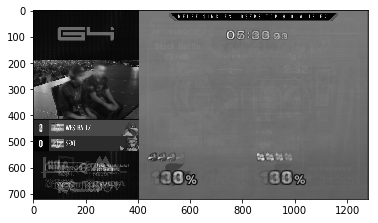

In [816]:
plt.imshow(A, cmap='gray')

In [377]:
img1 = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)

In [378]:
img1

array([[ 11,  11,  11, ..., 114,  92,  52],
       [ 11,  11,  11, ..., 115,  92,  52],
       [ 11,  11,  11, ..., 115,  92,  52],
       ..., 
       [ 11,  11,  11, ...,  95,  72,  42],
       [ 11,  11,  11, ...,  95,  72,  42],
       [ 11,  11,  11, ...,  95,  72,  42]], dtype=uint8)

In [877]:
# # Initialize video and data dictionary
# vid1 = VideoFileClip('Genesis 4 SSBM - G2 Westballz (Falco) Vs CLG  SFAT (Fox) Smash Melee Losers Top 12.mp4')
data_store = {}

# # Get average frame and health areas
# img = get_average_image(vid1)
# y_top, y_bottom, p1_x_left, p1_x_right, p2_x_left, p2_x_right = find_health_areas(img)

frame_num = 0
for frame in vid1.iter_frames(progress_bar=True):
    frame_num += 1
    
    # Convert frame to gray and extract health areas
    grayFrame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    p1_area, p2_area = extract_health_area(grayFrame)
    
    # Blur health frames
    p1_area = cv2.medianBlur(p1_area, 5)
    p2_area = cv2.medianBlur(p2_area, 5)
    
    p1_area, p2_area = binarize_blurred_healths(p1_area, p2_area)
    
    # Get health with OCR 
    p1h_ocr, p2h_ocr = ocr_health(p1_area, p2_area)

    data_store[frame_num] = (p1h_ocr, p2h_ocr)

100%|██████████| 20473/20473 [4:26:11<00:00,  3.26it/s]      


In [202]:
# data_store = {}
# frame_num = 0
# for frame in vid.iter_frames(progress_bar=True):
#     frame_num += 1
    
#     grayFrame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
#     p1h, p2h = ocr_health(grayFrame)
    
#     data_store[frame_num] = (p1h, p2h)
    

100%|██████████| 31431/31431 [2:34:41<00:00,  2.62it/s]   


In [879]:
len(data_store)

20473

In [882]:
data_store.values()

dict_values([('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''), ('', ''

In [880]:
df = raw_data_pipeline(data_store)

In [881]:
df.shape

(20473, 7)

In [843]:
df.shape

(4704, 7)

In [854]:
np.nan

nan

In [429]:
# df2 = df1.copy() # Keep an extra copy of the dataframe stored as variable df2

In [546]:
df1 = df2.copy()

In [547]:
df1.shape

(20473, 8)

In [549]:
df1.shape

(18353, 8)

Eliminate anomalies in player's health.  If the health has been read as a specific number for several frames, changes, then reverts back to the original number shortly afterwards, then it is likely an error.  How can I do this while making sure I'm not inferring incorrect numbers?

In [878]:
# Find combos
def find_combos(df):
    """Takes a cleaned dataframe of points in match and extracts combos/highlights.
    Returns (p1_combos, p2_combos), where p_combos = (start_time, stop_time, deltas)"""
    p1_combos = []
    i = 1
    while i < len(df)-1:
        i += 1
        if df.loc[i, 'p1_delta'] > 2 and df.loc[i, 'p1_delta'] < 30:
            p1_time = df.loc[i, 'frame']
            deltas = [df.loc[i, 'p1_delta']]
            start_sec = df.loc[i, 'second'] - 2
            start_time = convert_seconds_to_timestamp(start_sec)
            for j in range(i+1, len(df)):
                if df.loc[j, 'p1_delta'] > 2 and df.loc[j, 'p1_delta'] < 30 and ((df.loc[j, 'frame'] - p1_time) <= 75):
                    deltas.append(df.loc[j, 'p1_delta'])
                    p1_time = df.loc[j, 'frame']
                    stop_sec = df.loc[j, 'second'] + 2
                    stop_time = convert_seconds_to_timestamp(stop_sec)
                if ((df.loc[j, 'frame'] - p1_time) > 75):
                    i = j + 1
                    break
            # If combo is at least 4 hits and greater than 10%, append it to combos list
            if len(deltas) >= 3 and sum(deltas) >= 10:
                p1_combos.append((start_time, stop_time, deltas))
                
    # Find combos for player 2
    p2_combos = []
    i = 1
    while i < len(df)-1:
        i += 1
        if df.loc[i, 'p2_delta'] > 2 and df.loc[i, 'p2_delta'] < 30:
            p2_time = df.loc[i, 'frame']
            deltas = [df.loc[i, 'p2_delta']]
            start_sec = df.loc[i, 'second'] - 2
            start_time = convert_seconds_to_timestamp(start_sec)
            for j in range(i+1, len(df)):
                if df.loc[j, 'p2_delta'] > 2 and df.loc[j, 'p2_delta'] < 30 and ((df.loc[j, 'frame'] - p2_time) <= 75):
                    deltas.append(df.loc[j, 'p2_delta'])
                    p2_time = df.loc[j, 'frame']
                    stop_sec = df.loc[j, 'second'] + 2
                    stop_time = convert_seconds_to_timestamp(stop_sec)
                if ((df.loc[j, 'frame'] - p2_time) > 75):
                    i = j + 1
                    break
            # If combo is at least 4 hits and greater than 10%, append it to combos list
            duration = stop_sec - start_sec
            if len(deltas) >= 3 and sum(deltas) >= 10:
                p2_combos.append((start_time, stop_time, deltas, duration))
    
    #
    return (p2_combos, p1_combos)

In [883]:
p1_combos, p2_combos = find_combos(df)

In [884]:
p1_combos

[('0:00:17', '0:00:26', [12.0, 6.0, 10.0, 10.0, 3.0, 10.0, 10.0, 10.0], 9),
 ('0:00:44', '0:00:49', [12.0, 12.0, 15.0], 5),
 ('0:01:35', '0:01:44', [10.0, 18.0, 4.0, 10.0], 9),
 ('0:03:45',
  '0:03:54',
  [10.0, 16.0, 10.0, 6.0, 9.0, 9.0, 12.0, 15.0, 10.0],
  9),
 ('0:04:10', '0:04:19', [10.0, 5.0, 10.0, 10.0, 10.0, 12.0, 3.0, 13.0], 9),
 ('0:04:39', '0:04:46', [5.0, 4.0, 10.0, 15.0, 14.0], 7),
 ('0:05:05', '0:05:12', [3.0, 5.0, 4.0, 6.0], 7),
 ('0:05:29', '0:05:37', [10.0, 16.0, 20.0, 12.0], 8),
 ('0:06:21', '0:06:28', [16.0, 10.0, 10.0, 10.0], 7),
 ('0:06:47', '0:06:52', [20.0, 10.0, 13.0], 5),
 ('0:07:13', '0:07:20', [10.0, 12.0, 20.0, 12.0], 7),
 ('0:07:39',
  '0:07:47',
  [10.0, 15.0, 16.0, 8.0, 10.0, 6.0, 10.0, 5.0, 16.0, 16.0],
  8),
 ('0:08:05', '0:08:12', [10.0, 20.0, 3.0, 10.0, 10.0, 4.0, 3.0], 7),
 ('0:08:31', '0:08:40', [10.0, 10.0, 3.0, 10.0], 9),
 ('0:10:43', '0:10:48', [29.0, 15.0, 15.0], 5),
 ('0:11:07', '0:11:12', [4.0, 4.0, 3.0], 5)]

In [885]:
p2_combos

[('0:00:17', '0:00:24', [12.0, 6.0, 10.0, 10.0, 3.0, 10.0, 10.0]),
 ('0:00:44', '0:00:49', [12.0, 12.0, 15.0]),
 ('0:01:09', '0:01:16', [10.0, 14.0, 3.0]),
 ('0:01:35', '0:01:43', [10.0, 18.0, 4.0]),
 ('0:02:53', '0:03:02', [10.0, 10.0, 10.0, 10.0, 15.0]),
 ('0:03:45', '0:03:54', [10.0, 10.0, 10.0, 6.0, 9.0, 9.0, 12.0, 15.0]),
 ('0:04:10', '0:04:19', [10.0, 5.0, 10.0, 10.0, 10.0, 12.0, 3.0, 13.0]),
 ('0:04:39', '0:04:46', [5.0, 4.0, 10.0, 15.0, 14.0]),
 ('0:05:05', '0:05:12', [3.0, 5.0, 4.0]),
 ('0:05:30', '0:05:37', [16.0, 20.0, 12.0]),
 ('0:06:21', '0:06:28', [10.0, 10.0, 16.0, 10.0, 10.0, 10.0]),
 ('0:07:13', '0:07:20', [10.0, 12.0, 20.0, 12.0]),
 ('0:07:39', '0:07:47', [15.0, 16.0, 8.0, 10.0, 6.0, 10.0, 5.0, 16.0, 16.0]),
 ('0:08:05', '0:08:12', [10.0, 20.0, 3.0, 10.0, 10.0, 4.0, 3.0]),
 ('0:10:43', '0:10:50', [29.0, 15.0, 15.0, 16.0]),
 ('0:11:07', '0:11:12', [4.0, 4.0, 3.0])]

('0:06:42', '0:06:45', [15.0, 11.0, 9.0, 20.0, 4.0]),
 ('0:06:47', '0:06:50', [20.0, 20.0, 20.0, 20.0, 20.0, 9.0, 14.0, 7.0]),

In [664]:
clip = vid1.subclip('0:01:31', '0:01:34')

In [665]:
clip.write_videofile('test_clip.mp4')

[MoviePy] >>>> Building video test_clip.mp4
[MoviePy] Writing audio in test_clipTEMP_MPY_wvf_snd.mp3


100%|██████████| 67/67 [00:00<00:00, 580.89it/s]

[MoviePy] Done.
[MoviePy] Writing video test_clip.mp4



 99%|█████████▉| 90/91 [00:01<00:00, 50.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_clip.mp4 



In [681]:
def extract_clips(combos, player):
    """Takes an array of the combos found and creates highlight clips"""
    for num, C in enumerate(combos):
        filename = "{}_clip_{}.mp4".format(player, num+1)
        clip = vid1.subclip(C[0], C[1])
        clip.write_videofile(filename, progress_bar=False)
        # Write clip to bucket

In [729]:
extract_clips(p1_combos, 'Westballz')

[MoviePy] >>>> Building video Westballz_clip_1.mp4
[MoviePy] Writing audio in Westballz_clip_1TEMP_MPY_wvf_snd.mp3
[MoviePy] Done.
[MoviePy] Writing video Westballz_clip_1.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Westballz_clip_1.mp4 

[MoviePy] >>>> Building video Westballz_clip_2.mp4
[MoviePy] Writing audio in Westballz_clip_2TEMP_MPY_wvf_snd.mp3
[MoviePy] Done.
[MoviePy] Writing video Westballz_clip_2.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Westballz_clip_2.mp4 

[MoviePy] >>>> Building video Westballz_clip_3.mp4
[MoviePy] Writing audio in Westballz_clip_3TEMP_MPY_wvf_snd.mp3
[MoviePy] Done.
[MoviePy] Writing video Westballz_clip_3.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Westballz_clip_3.mp4 

[MoviePy] >>>> Building video Westballz_clip_4.mp4
[MoviePy] Writing audio in Westballz_clip_4TEMP_MPY_wvf_snd.mp3
[MoviePy] Done.
[MoviePy] Writing video Westballz_clip_4.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Westballz_clip_4.mp4 

[MoviePy] >>>> Building vide

In [730]:
extract_clips(p2_combos, 'Sfat')

[MoviePy] >>>> Building video Sfat_clip_1.mp4
[MoviePy] Writing audio in Sfat_clip_1TEMP_MPY_wvf_snd.mp3
[MoviePy] Done.
[MoviePy] Writing video Sfat_clip_1.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Sfat_clip_1.mp4 

[MoviePy] >>>> Building video Sfat_clip_2.mp4
[MoviePy] Writing audio in Sfat_clip_2TEMP_MPY_wvf_snd.mp3
[MoviePy] Done.
[MoviePy] Writing video Sfat_clip_2.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Sfat_clip_2.mp4 

[MoviePy] >>>> Building video Sfat_clip_3.mp4
[MoviePy] Writing audio in Sfat_clip_3TEMP_MPY_wvf_snd.mp3
[MoviePy] Done.
[MoviePy] Writing video Sfat_clip_3.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Sfat_clip_3.mp4 

[MoviePy] >>>> Building video Sfat_clip_4.mp4
[MoviePy] Writing audio in Sfat_clip_4TEMP_MPY_wvf_snd.mp3
[MoviePy] Done.
[MoviePy] Writing video Sfat_clip_4.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Sfat_clip_4.mp4 

[MoviePy] >>>> Building video Sfat_clip_5.mp4
[MoviePy] Writing audio in Sfat_clip_5TEMP_MPY_wvf_snd.mp3
[Mo

In [674]:
import boto
import os

In [676]:
access_key, access_secret_key = os.environ['AWS_ACCESS_KEY_ID'], os.environ['AWS_SECRET_ACCESS_KEY']
conn = boto.connect_s3(access_key, access_secret_key)
bucket = conn.get_bucket('smashclips')

In [677]:
print (bucket)

<Bucket: smashclips>


In [685]:
A = bucket.get_all_keys()

In [686]:
type(A)

boto.resultset.ResultSet

In [690]:
B = A[0]

In [750]:
B

<Key: smashclips,Alien (Falcon) vs Rustin (Peach)  SSBM Pools  DPG.mp4>

In [738]:
video_file = bucket.get_key(B.name)

In [743]:
video_file.get_contents_to_filename('~/'.format(video_file.name))

In [749]:
for b in bucket.list():
    print (b)

<Key: smashclips,Alien (Falcon) vs Rustin (Peach)  SSBM Pools  DPG.mp4>
<Key: smashclips,Amrit (Fox) vs Comfort (Marth)  SSBM Pools  DPG.mp4>
<Key: smashclips,BEAST 7 - Asterion  Amsah (Sheik) Vs MSF  The Moon (Marth) - Losers Quarters - Melee Singles.mp4>
<Key: smashclips,BEAST 7 - Druggedfox (Fox) Vs LG  Ice (Fox) - Losers Quarters - Melee Singles.mp4>
<Key: smashclips,BEAST 7 - MSF  The Moon (Marth) Vs LG  Ice (Fox) - Losers Semis - Melee Singles.mp4>
<Key: smashclips,BEAST 7 - MSF  The Moon (Marth) Vs TSM RB  Leffen - Winners Semis - Melee Singles.mp4>
<Key: smashclips,BEAST 7 - Slox (Fox) Vs Druggedfox (Fox) - Losers Top 8 - Melee.mp4>
<Key: smashclips,BEAST 7 - TSM RB  Leffen (Fox) Vs LG  Ice (Fox) - Losers Final - Melee Singles.mp4>
<Key: smashclips,BEAST 7 - [A]ndroid (Sheik) Vs Asterion  Amsah (Sheik) - Losers Top 8 - Melee Singles.mp4>
<Key: smashclips,BEAST 7 - [A]rmada (Fox) Vs RB TSM  Leffen (Fox) - Grand Finals - Melee Singles.mp4>
<Key: smashclips,BEAST 7 - [A]rmada (Pea

In [745]:
Z = bucket.get_key('wrong')

In [747]:
type(Z)

NoneType

In [748]:
Z.get_contents()

AttributeError: 'NoneType' object has no attribute 'get_contents'

In [751]:
clip_names = ['1', '2', '3']
combos = [['start', 'stop', [3, 4, 5]], ['start', 'stop', [6, 7, 8]], ['start', 'stop', [9, 10, 11]]]

In [774]:
i = 0
for name, com in zip(clip_names, combos):
    print (name, com[2], sum(com[2]))
    df_sql.loc[i] = [name, com[2], sum(com[2])]
    i += 1

1 [3, 4, 5] 12
2 [6, 7, 8] 21
3 [9, 10, 11] 30


In [768]:
df_sql = pd.DataFrame(columns=['clip_name', 'deltas', 'total_damage'])

In [775]:
df_sql

,clip_name,deltas,total_damage
0,1,"[3, 4, 5]",12
1,2,"[6, 7, 8]",21
2,3,"[9, 10, 11]",30


In [784]:
"DBUSER" in os.environ

False

In [823]:
plt.imsave(fname = 'im2', arr = vid1.get_frame(400))

In [822]:
plt.imsave(fname = 'im1', arr = vid.get_frame(79))

In [818]:
A = vid.get_frame(79)

In [824]:
TEMPLATE

array([[105, 111, 109, ..., 107, 107, 107],
       [104, 109, 108, ..., 107, 107, 107],
       [100, 106, 104, ..., 107, 107, 107],
       ..., 
       [128, 128, 125, ..., 104, 107, 108],
       [129, 129, 129, ..., 107, 108, 108],
       [129, 129, 129, ..., 107, 108, 108]], dtype=uint8)

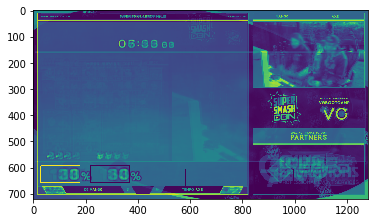

In [842]:
plt.imshow(avg_image)

In [838]:
# img = get_average_image(vid1)
y_top, y_bottom, p1_x_left, p1_x_right, p2_x_left, p2_x_right = find_health_areas(avg_image)

In [839]:

cv2.rectangle(avg_image, (p1_x_left, y_top), (p1_x_right, y_bottom), color=[0,0,0], thickness=2) # draw rectangle
cv2.rectangle(avg_image, (p2_x_left, y_top), (p2_x_right, y_bottom), color=[0,0,0], thickness=2) # draw rectangle
plt.imsave(fname='health',arr=avg_image, cmap='gray')

In [840]:
plt.imsave(fname='bwtemp', arr=TEMPLATE, cmap='gray')

In [841]:
print (y_top, y_bottom, p1_x_left, p1_x_right, p2_x_left, p2_x_right)

593 658 220 370 219 369


In [876]:
df[(600 <= df.second) & (df.second <= 601)]

,p1_health,p2_health,frame,second,timestamp,p1_delta,p2_delta
17999,NaN,67.0,18000,600,0:10:00,NaN,0.0
18000,NaN,NaN,18001,600,0:10:00,NaN,NaN
18001,NaN,NaN,18002,600,0:10:00,NaN,NaN
18002,NaN,NaN,18003,600,0:10:00,NaN,NaN
18003,NaN,67.0,18004,600,0:10:00,NaN,NaN
18004,NaN,67.0,18005,600,0:10:00,NaN,0.0
18005,NaN,67.0,18006,600,0:10:00,NaN,0.0
18006,NaN,67.0,18007,600,0:10:00,NaN,0.0
18007,NaN,67.0,18008,600,0:10:00,NaN,0.0
18008,NaN,67.0,18009,600,0:10:00,NaN,0.0
